
# Neural-HMM synthesis notebook

## Location of the model checkpoints

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
%load_ext autoreload
%autoreload 3

## Import libraries and setup matplotlib

In [3]:
import matplotlib.pylab as plt

# # Download tokenizer if not present
# import nltk
# nltk.download('punkt')

import IPython.display as ipd 
import os
import json
import sys
sys.path.append('src/model')
sys.path.insert(0, './hifigan')
import numpy as np
import torch
import warnings

from src.hparams import create_hparams
from src.training_module import TrainingModule
from src.utilities.text import cleaned_text_to_sequence, intersperse, _clean_text, sequence_to_text
from hifigan.env import AttrDict
from hifigan.models import Generator
from nltk import word_tokenize
from hifigandenoiser import Denoiser
%matplotlib inline
from pathlib import Path


from src.utilities.plotting import generate_motion_visualization



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
%ls checkpoints/ConformerEvery4NoConv

checkpoint_0.ckpt      checkpoint_42500.ckpt  checkpoint_60000.ckpt
checkpoint_10000.ckpt  checkpoint_43000.ckpt  checkpoint_60500.ckpt
checkpoint_1000.ckpt   checkpoint_43500.ckpt  checkpoint_61000.ckpt
checkpoint_15000.ckpt  checkpoint_44000.ckpt  checkpoint_61500.ckpt
checkpoint_1500.ckpt   checkpoint_44500.ckpt  checkpoint_62000.ckpt
checkpoint_20000.ckpt  checkpoint_45000.ckpt  checkpoint_62500.ckpt
checkpoint_2000.ckpt   checkpoint_45500.ckpt  checkpoint_63000.ckpt
checkpoint_25000.ckpt  checkpoint_46000.ckpt  checkpoint_63500.ckpt
checkpoint_2500.ckpt   checkpoint_46500.ckpt  checkpoint_64000.ckpt
checkpoint_28500.ckpt  checkpoint_47000.ckpt  checkpoint_64500.ckpt
checkpoint_29000.ckpt  checkpoint_47500.ckpt  checkpoint_65000.ckpt
checkpoint_29500.ckpt  checkpoint_48000.ckpt  checkpoint_65500.ckpt
checkpoint_30000.ckpt  checkpoint_48500.ckpt  checkpoint_66000.ckpt
checkpoint_30500.ckpt  checkpoint_49000.ckpt  checkpoint_66500.ckpt
checkpoint_31000.ckpt  checkpoint_49500.ckpt  ch

In [7]:
checkpoint_path = "checkpoints/ConformerEvery4NoConv/checkpoint_77000.ckpt"

## Plotting code

In [8]:
def plot_spectrogram_to_numpy(spectrogram):
    fig, ax = plt.subplots(figsize=(12, 3))
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",
                   interpolation='none')
    plt.colorbar(im, ax=ax)
    plt.xlabel("Frames")
    plt.ylabel("Channels")
    plt.title("Synthesised Mel-Spectrogram")
    fig.canvas.draw()
    plt.show()
    
def plot_hidden_states(hidden_states):
    plt.plot(hidden_states)
    plt.xlabel("Time steps")
    plt.ylabel("HMM states")
    plt.title("Hidden states vs Time")
    plt.show()

## Setup hparams

In [9]:
hparams = create_hparams()

In [10]:
x = torch.load(checkpoint_path, map_location="cuda")
# # x['hyper_parameters']['encoder_type'] = "transformer"
# # # x['hyper_parameters']['encoder_params'] = {
# # #             "conv": {"kernel_size": 5, "n_convolutions": 3, "hidden_channels": 512, "state_per_phone": 2},
# # #             "transformer": {
# # #                 "hidden_channels": 384,
# # #                 "n_layer": 6,
# # #                 "n_head": 1,
# # #                 "d_head": 64,
# # #                 "d_inner": 1024,
# # #                 "kernel_size": 3,
# # #                 "dropout": 0.1,
# # #                 "dropatt": 0.1,
# # #                 "dropemb": 0.0,
# # #                 "embed_input": False,
# # #                 "pre_lnorm": True,
# # #                 "rel_attention": True,
# # #             },
# # #         }
# # torch.save(x, checkpoint_path)

In [11]:
x['hyper_parameters']['motion_visualizer'] = hparams.motion_visualizer

# x['hyper_parameters']['n_motion_joints'] = hparams.n_motion_joints
# x['hyper_parameters']['base_sampling_temperature'] = hparams.base_sampling_temperature
torch.save(x, checkpoint_path)


In [12]:
model = TrainingModule.load_from_checkpoint(checkpoint_path)
_ = model.to(device).eval().half()

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 49,888,990 trainable parameters


## Load Hifi-gan for mel2audio synthesis and denoiser

In [14]:
def load_checkpoint(filepath, device):
    print(filepath)
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict

In [15]:
# load the hifi-gan model
hifigan_loc = 'hifigan/'
config_file = hifigan_loc + 'config_v1.json'
hifi_checkpoint_file = 'g_02500000'
with open(config_file) as f:
    data = f.read()
json_config = json.loads(data)

In [16]:
h = AttrDict(json_config)
torch.manual_seed(h.seed)
generator = Generator(h).to(device)
state_dict_g = load_checkpoint(hifi_checkpoint_file, device)
generator.load_state_dict(state_dict_g['generator'])
generator.eval().half()
generator.remove_weight_norm()

denoiser = Denoiser(generator, mode='zeros')

g_02500000
Loading 'g_02500000'
Complete.
Removing weight norm...


### Usage
1. Increase max_sampling_time for longer utterances
2. Increase duration_quantile_threshold for faster speaking rate
3. Set deterministic_transaction as False for model sampled transition probabilities
4. Set predict_means to False to synthesis a sample instead of just means of gaussians
5. Set prenet_dropout_while_eval to False to turn off dropout in the prenet module

In [17]:
model.model.hmm.hparams.max_sampling_time = 10000
model.model.hmm.hparams.duration_quantile_threshold=0.3
model.model.hmm.hparams.deterministic_transition=True
model.model.hmm.hparams.predict_means=False
model.model.hmm.hparams.prenet_dropout_while_eval=True

## Set texts

In [18]:
texts = [
    "THE DIFFERENCE IN THE RAINBOW DEPENDS CONSIDERABLY UPON THE SIZE OF THE DROPS."
]

In [19]:
test_sentences = {
    1: "WHEN THE SUNLIGHT STRIKES RAINDROPS IN THE AIR THEY ACT AS A PRISM AND FORM A RAINBOW.",
    2: "THESE TAKE THE SHAPE ; OF A LONG ROUND ARCH, WITH ITS PATH HIGH ABOVE, AND ITS TWO ENDS APPARENTLY BEYOND THE HORIZON.",
    3: "WHEN A MAN LOOKS FOR SOMETHING BEYOND HIS REACH, HIS FRIENDS SAY HE IS LOOKING FOR THE POT OF GOLD AT THE END OF THE RAINBOW.",
    4: "IF THE RED OF THE SECOND BOW FALLS UPON THE GREEN OF THE FIRST, THE RESULT IS TO GIVE A BOW WITH AN ABNORMALLY WIDE YELLOW BAND.",
    5: "THE ACTUAL PRIMARY RAINBOW OBSERVED IS SAID TO BE THE EFFECT OF SUPER IMPOSITION OF A NUMBER OF BOWS.",
    6: "THE DIFFERENCE IN THE RAINBOW DEPENDS CONSIDERABLY UPON THE SIZE OF THE DROPS.",
    7: "IN THIS PERSPECTIVE, WE HAVE REVIEWED SOME OF THE MANY WAYS IN WHICH NEUROSCIENCE HAS MADE FUNDAMENTAL CONTRIBUTIONS.",
    8: "IN ENHANCING AGENT CAPABILITIES, IT WILL BE IMPORTANT TO CONSIDER OTHER SALIENT PROPERTIES OF THIS PROCESS IN HUMANS.",
    9: "IN A WAY THAT COULD SUPPORT DISCOVERY OF SUB GOALS AND HIERARCHICAL PLANNING.",
    10: "DISTILLING INTELLIGENCE INTO AN ALGORITHMIC CONSTRUCT AND COMPARING IT TO THE HUMAN BRAIN MIGHT YIELD INSIGHTS.",
    11: "THE VAULT THAT WAS SEARCHED HAD IN FACT BEEN EMPTIED EARLIER THAT SAME DAY.",
    12: "ANT LIVES NEXT TO GRASSHOPPER, ANT SAYS, I LIKE TO WORK EVERY DAY.",
    13: "YOUR MEANS OF TRANSPORT FULFIL ECONOMIC REQUIREMENTS IN YOUR CHOSEN COUNTRY.",
    14: "SLEEP STILL FOGGED MY MIND AND ATTEMPTED TO FIGHT BACK THE PANIC.",
    15: "SUDDENLY, I SAW TWO FAST AND FURIOUS ; FEET DRIBBLING THE ; BALL TOWARDS MY GOAL.",
}

# texts = [" ".join(test_sentences.values())]
texts = [list(test_sentences.values())[0]]

texts = [
    "; , Finish at like six; , or maybe seven or eight; then we'd all go out, you know have a few drinks head out to a nightclub or something like that come home."
]

In [20]:
# texts = [
#     "We propose a new approach, OverFlow, to address the shortcomings of neural HMM TTS (a type of transducer TTS) by adding flows over them. Having a stronger probabilistic model, we can now describe the highly non-Gaussian distribution of speech acoustics, WHEN THE SUNLIGHT STRIKES RAINDROPS IN THE AIR ; THEY ACT AS A PRISM AND FORM A RAINBOW. IN THIS PERSPECTIVE, WE HAVE REVIEWED SOME OF THE MANY WAYS IN WHICH NEUROSCIENCE HAS MADE FUNDAMENTAL CONTRIBUTIONS."
# ]

In [21]:
def get_text(i, text):
    print(f"\n{''.join(['*'] * 20)}\n{i + 1} - Input text: \n{''.join(['*'] * 20)}\n{text}")
    text = _clean_text(text, hparams.text_cleaners)
    print(f"\n{''.join(['*'] * 20)}\n{i + 1} - Phonetised text: \n{''.join(['*'] * 20)}\n{text}")
    sequence = cleaned_text_to_sequence(text)    
    if hparams.add_blank:
        sequence = intersperse(sequence, 0)
    sequence = torch.LongTensor(sequence).to(device)
    print(''.join(['='] * 100))
    return sequence

In [22]:
sequences = []

for i, text in enumerate(texts):
    sequence = get_text(i, text)
    sequences.append(sequence)


********************
1 - Input text: 
********************
; , Finish at like six; , or maybe seven or eight; then we'd all go out, you know have a few drinks head out to a nightclub or something like that come home.

********************
1 - Phonetised text: 
********************
; , fˈɪnɪʃ æt lˈaɪk sˈɪks; , ɔːɹ mˈeɪbiː sˈɛvən ɔːɹ ˈeɪt; ðˈɛn wiːd ˈɔːl ɡˌoʊ ˈaʊt, juː nˈoʊ hæv ɐ fjˈuː dɹˈɪŋks hˈɛd ˈaʊt tʊ ɐ nˈaɪtklʌb ɔːɹ sˈʌmθɪŋ lˈaɪk ðæt kˈʌm hˈoʊm.


In [23]:
sequence_to_text(sequence.tolist())

'_;_ _,_ _f_ˈ_ɪ_n_ɪ_ʃ_ _æ_t_ _l_ˈ_a_ɪ_k_ _s_ˈ_ɪ_k_s_;_ _,_ _ɔ_ː_ɹ_ _m_ˈ_e_ɪ_b_i_ː_ _s_ˈ_ɛ_v_ə_n_ _ɔ_ː_ɹ_ _ˈ_e_ɪ_t_;_ _ð_ˈ_ɛ_n_ _w_i_ː_d_ _ˈ_ɔ_ː_l_ _ɡ_ˌ_o_ʊ_ _ˈ_a_ʊ_t_,_ _j_u_ː_ _n_ˈ_o_ʊ_ _h_æ_v_ _ɐ_ _f_j_ˈ_u_ː_ _d_ɹ_ˈ_ɪ_ŋ_k_s_ _h_ˈ_ɛ_d_ _ˈ_a_ʊ_t_ _t_ʊ_ _ɐ_ _n_ˈ_a_ɪ_t_k_l_ʌ_b_ _ɔ_ː_ɹ_ _s_ˈ_ʌ_m_θ_ɪ_ŋ_ _l_ˈ_a_ɪ_k_ _ð_æ_t_ _k_ˈ_ʌ_m_ _h_ˈ_o_ʊ_m_._'

## Decode text input and plot results

In [26]:
t = {
    'audio' :0.667,
    'motion': 0.0,
}
t = 0.334


In [33]:
from tqdm.auto import tqdm
with torch.no_grad():
    mel_outputs, motion_outputs = [], []
    for sequence in tqdm(sequences, leave=False):
        mel_output, motion_output, hidden_state_travelled, _, _ = model.sample(sequence.squeeze(0), sampling_temp=t)
        mel_outputs.append(mel_output)
        motion_outputs.append(motion_output)
        

  0%|          | 0/1 [00:00<?, ?it/s]

### Visualisations of the output

0 ; , Finish at like six; , or maybe seven or eight; then we'd all go out, you know have a few drinks head out to a nightclub or something like that come home.


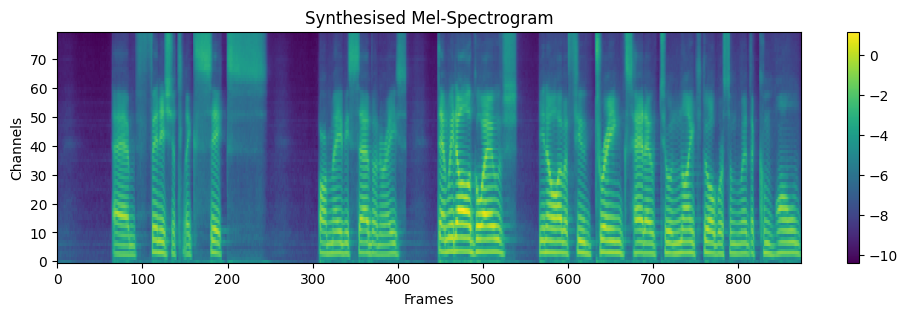

In [34]:
for i, mel_output in enumerate(mel_outputs):
    print(i, texts[i])
    plot_spectrogram_to_numpy(np.array(mel_output.float().cpu()).T)

### Synthesize audio from spectrogram using HiFiGAN

### Interesting denoising

In [35]:
with torch.no_grad():
    audios = []
    for i, mel_output in enumerate(mel_outputs):
        mel_output = mel_output.transpose(1, 2)
        audio = generator(mel_output)
        audio = denoiser(audio[:, 0], strength=0.001)[:, 0]
        audios.append(audio)
        print(f"{''.join(['*'] * 10)} \t{i + 1}\t {''.join(['*'] * 10)}")
        print(f"Text: {texts[i]}")
        ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate))
        print(f"{''.join(['*'] * 35)}\n")


********** 	1	 **********
Text: ; , Finish at like six; , or maybe seven or eight; then we'd all go out, you know have a few drinks head out to a nightclub or something like that come home.


***********************************



### Synthesise motion

In [36]:
output_folder = Path('syn_motion_output')
output_folder.mkdir(exist_ok=True, parents=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i, motion_output in tqdm(enumerate(motion_outputs)):
        generate_motion_visualization(audios[i].cpu(), output_folder/f'{i + 1}.wav', motion_output.cpu().squeeze(0)[:, :45], output_folder/f'{i+1}.mp4', hparams.motion_visualizer)
        ipd.Video(output_folder/f'{i+1}.mp4')

0it [00:00, ?it/s]

MocapParameterizer: position


ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/home/smehta/anaconda3/envs/LightningTacotron --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample  

In [37]:
ipd.Video(output_folder/f'{i+1}.mp4')

### Save to wav files using soundfile

In [ ]:
import soundfile as sf
from pathlib import Path

basepath = Path('synthesised_wavs')
basepath.mkdir(parents=True, exist_ok=True)

for i, audio in enumerate(audios):
        filename = basepath / f'OverFlow_{i + 1}.wav'
        sr = 22500
        sf.write(filename, audio.data.squeeze().cpu().numpy(), 
                 22500, 'PCM_24')
        print(f'Successfully written: {filename}')
